<a href="https://colab.research.google.com/github/PratikhyaManas/Pneumonia_Classification_CNN/blob/main/PneumoniaClassification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uploading the Kaggle Json File for Downloading the Dataset
from google.colab import files
files.upload()

In [5]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Nov  4 18:03 kaggle.json


In [6]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [7]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Downloading the Dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 32.8MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.4MB/s]


In [11]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [12]:
# Importing the Required Libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import numpy as np
import seaborn as sns

In [16]:
# Checking the content of the Dataset
DIR = os.listdir('/content/chest_xray/chest_xray')
print(DIR)

['test', 'val', 'train', '.DS_Store']


In [17]:
# Specifying the Path to the Dataset
train_folder = '/content/chest_xray/chest_xray/train'
test_folder = '/content/chest_xray/chest_xray/test'
val_folder = '/content/chest_xray/chest_xray/val'

In [18]:
# Importing some plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

In [33]:
labels = ["NORMAL", "PNEUMONIA"] # each folder has two sub folder name "PNEUMONIA", "NORMAL"
IMG_SIZE = 150 # resize image

def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [34]:
train = get_data_train(train_folder)
test = get_data_train(test_folder)
val = get_data_train(val_folder)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


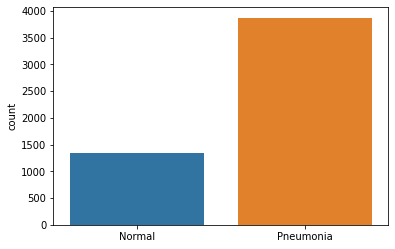

In [35]:
# Data Visualization. 
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")
        
sns.countplot(l)

In [36]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [37]:
# Normalizing the Data
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [38]:
X_test.shape

(624, 150, 150)

In [39]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [40]:
# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [41]:
datagen.fit(X_train)

In [61]:
# Model Architecture
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=X_train.shape[1:],activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32),epochs = 25,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks = [learning_rate_reduction])
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

model.save("cnn.model")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 17, 17, 128)      

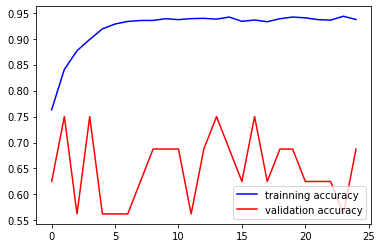

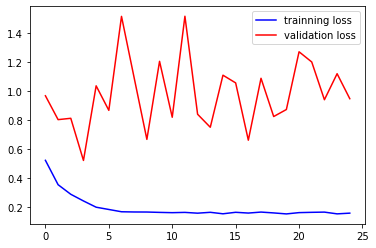

In [62]:
# Plotting the Accuracy and Losses during Training
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [63]:
# predict classes
prediction = model.predict_classes(X_test)
prediction = prediction.reshape(1, -1)[0]
prediction[:15]

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [64]:
# correct and Incorrect
correct = np.nonzero(prediction == y_test)[0]
incorrect = np.nonzero(prediction != y_test)[0]

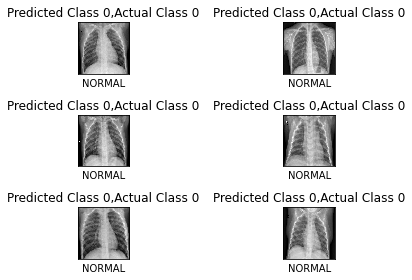

In [65]:
# Visualize Some Correct Result
j = 0
for i in correct[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

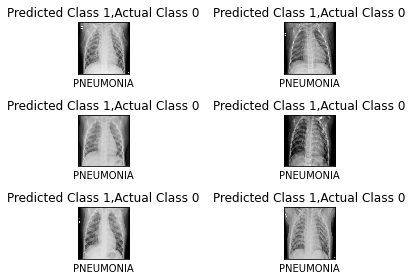

In [66]:
# Visualize Some Wrong Results
j = 0
for i in incorrect[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

In [67]:
# load model and predict some some external photo

labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("/content/cnn.model") 

In [74]:
# extra pneumonia photo from google
prediction = model.predict([prepare("/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg")])
print(labels[int(prediction[0])])

PNEUMONIA
